In [1]:
#Import everything needed for matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
#Import of libraries to be used
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
 # Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
#Create the engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#Create the base and automap the classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [6]:
#Now to assign the classes to variable
Station = Base.classes.station
Measurement = Base.classes.measurement

In [7]:
#Create a session
session = Session(engine)

In [ ]:
#first_row_station = session.query(Station).first()
#first_row_station.__dict__

In [ ]:
#first_row_measurement = session.query(Measurement).first()
#first_row_measurement.__dict__

In [8]:
#The date is presented in a text format which is another wrinkle to work with
#First we can use strftime and some functions to find the most recent date
top_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date)))

#From this we can pull out out a a string of the date
top_date_date = dt.datetime.strptime(top_date[0][0], "%Y-%m-%d")

#Now I need a variable that is the date 1 year ago. I used weeks=52.2 since 52*7 /= 365
year_ago = top_date_date - dt.timedelta(weeks=52.2)

In [9]:
#Now To put my query into a variable
qry = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= year_ago)

#Making a dataframe from the query
measurement_df = pd.read_sql(qry.statement, session.bind)

#Set the date to the index
measurement2_df = measurement_df.set_index('date')

#Finally to sort
measurement3_df = measurement2_df.sort_index(ascending = True)

measurement3_df.tail()

,prcp
date,
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45


Text(0, 0.5, 'Inches')

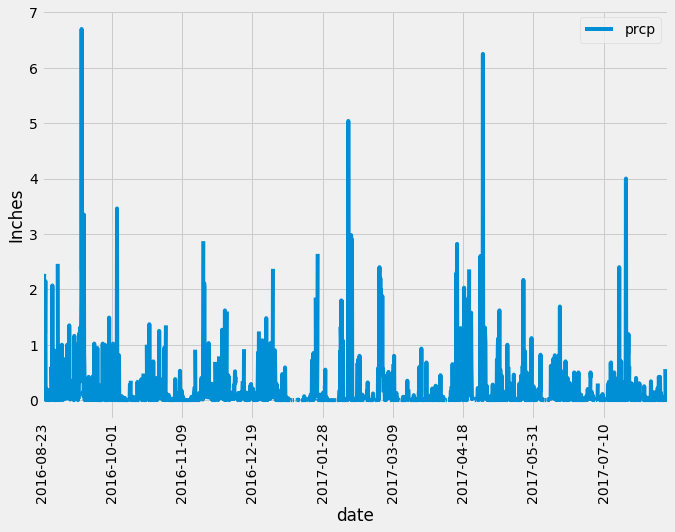

In [10]:
#Now to make a pretty little graph
fig, ax = plt.subplots(figsize = (10, 7))
measurement3_df.plot(ax = ax, x_compat = True,rot=90)
ax.set_ylabel('Inches')

In [11]:
#Print out the statistics for the precipitation
measurement3_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
#Query to count the total number of stations
qry_station_count = session.query(Station.station).group_by(Station.station).count()
qry_station_count

9

In [13]:
#Make a query to find the activity of each station reporting
qry_station_active = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

#Here is my list, there are many like it, but this one is mine
print(qry_station_active)

#The first entry is the most active since this is descending order
most_active = qry_station_active[0][0]
print("\n" + "The most active station is " + str(most_active))

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]

The most active station is USC00519281


In [14]:
#Next we want to make query for the average temperature readings for the most active station
temperature_readings = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                                     filter(Measurement.station == most_active).all()
temperature_readings

[(54.0, 85.0, 71.66378066378067)]

In [15]:
#Now a query for the temperature readings for the last year of the most active station
qry_temp = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= year_ago).\
                        filter(Measurement.station == most_active)

#Making a dataframe from the query
temperature_df = pd.read_sql(qry_temp.statement, session.bind)


Text(0.5, 0, 'Temperature')

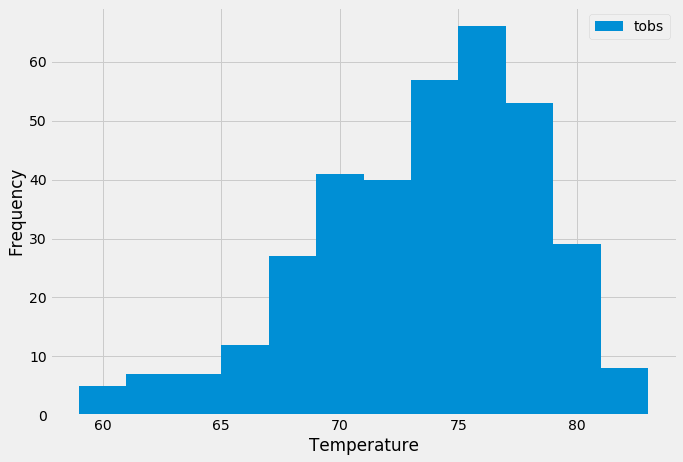

In [16]:
#Now to make a pretty little graph
fig, ax = plt.subplots(figsize = (10, 7))
temperature_df.plot.hist(ax = ax, bins = 12)
ax.set_ylabel('Frequency')
ax.set_xlabel('Temperature')

In [17]:
###Bonus

In [22]:
#We are asked to find the average temperature during the month of june and december and see if there is a statistical difference
#First to find the average for June
qry_june_temp = session.query(func.avg(Measurement.tobs)).\
                        filter(func.strftime("%m",Measurement.date) == "06").all()
qry_june_temp

[(74.94411764705882)]

In [23]:
#Now to find the average for december
qry_dec_temp = session.query(func.avg(Measurement.tobs)).\
                        filter(func.strftime("%m",Measurement.date) == "12").all()
qry_dec_temp

[(71.04152933421226)]

In [33]:
#To find if they are statistically equivelent we need the list of values for December and June
qry_june_temp_all = session.query(Measurement.tobs).\
                        filter(func.strftime("%m",Measurement.date) == "06").all()

qry_dec_temp_all = session.query(Measurement.tobs).\
                        filter(func.strftime("%m",Measurement.date) == "12").all()
#len(qry_june_temp_all)
#len(qry_dec_temp_all)

from scipy import stats

t2, p2 = stats.ttest_ind(qry_june_temp_all,qry_dec_temp_all)
t2

array([31.60372399])